In [1]:
import re
import networkx as nx
import matplotlib.pyplot as plt

## Entrada do Usuário

In [2]:
database = {
    "Usuario": ["idUsuario", "Nome", "Logradouro", "Numero", "Bairro", "CEP", "UF", "DataNascimento"],
    "Contas": ["idConta", "Descricao", "TipoConta_idTipoConta", "Usuario_idUsuario", "SaldoInicial"],
    "Movimentacao": ["idMovimentacao", "DataMovimentacao", "Descricao", "TipoMovimento_idTipoMovimento", "Categoria_idCategoria", "Contas_idConta", "Valor"],
    "TipoConta": ["idTipoConta", "Descrição"],
    "TipoMovimento": ["idTipoMovimento", "DescMovimentacao"],
    "Categoria": ["idCategoria", "DescCategoria"]
}

In [3]:
operators = ['=', '>', '<', '<=', '>=', '<>', 'and', 'in', 'not In', '(', ')']
operatorsBasics = ['=', '>', '<', '<=', '>=', '<>', 'in', 'not in']

In [4]:
commands = ['sigma', 'pi', '|x|']

In [5]:
#entradaUsuario = input("Escreva o comando SQL")
entradaUsuario = "Select nome, datanascimento, descricao, saldoinicial from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario where saldoinicial >= 235 and uf ='ce' and cep <> '62930000';"
#entradaUsuario = "Select idusuario, nome, datanascimento, descricao, saldoinicial, UF, Descrição from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario join tipoconta on tipoconta.idTipoConta = contas.TipoConta_idTipoConta where saldoinicial < 3000 and uf = 'ce' and Descrição <> 'Conta Corrente' and idusuario > 3;"

entradaUsuario

"Select nome, datanascimento, descricao, saldoinicial from usuario join contas on usuario.idUsuario = contas.Usuario_idUsuario where saldoinicial >= 235 and uf ='ce' and cep <> '62930000';"

## Grafo de Operadores

In [6]:
testeBase = "Pi Nome ( Sigma Uf = 'CE' ( USUARIO |X| usuario.idusuario = contas.usuario_idusuario CONTAS ) )"
testeBase2 = "Pi Nome ( Sigma Uf = 'CE' and SaldoInicial = 200 ( USUARIO |X| usuario.idusuario = contas.usuario_idusuario CONTAS ) )"
testeBase3 = "Pi Nome , SaldoInicial ( Sigma Uf = 'CE' and SaldoInicial = 200 ( USUARIO |X| usuario.idusuario = contas.usuario_idusuario CONTAS ) )"
testeBase4 = "Pi Nome ( USUARIO |X| usuario.idusuario = contas.usuario_idusuario CONTAS )"

teste1 = "SIGMA UF = 'CE' ( USUARIO )"
teste2 = 'PI Nome , Datanascimento , idConta , Descricao ( usuario |X| usuario.idusuario = Contas.Usuario_idUsuario Contas )'
teste3 = 'PI Nome , Datanascimento , idConta , Descricao ( SIGMA UF = "CE" AND NOME = "ALEX" ( usuario |X| usuario.idusuario = Contas.Usuario_idUsuario Contas ) )'
#teste4 = 'PI DescCategoria ( ( SIGMA DescCategoria = "VIP" ( Categoria ) ) |X| Movimentacao.Categoria_idCategoria = Categoria.idCategoria Movimentacao ) )'

testeProf1 = "PI nome , datanascimento , descricao , saldoinicial ( SIGMA saldoinicial >= 235 and uf = 'ce' and cep <> '62930000' ( usuario |X| usuario.idUsuario = contas.Usuario_idUsuario contas ) )"
testeProf2 = "PI idusuario , nome , datanascimento , descricao , saldoinicial , UF , Descrição ( SIGMA saldoinicial < 3000 and uf = 'ce' and Descrição <> 'Conta Corrente' and idusuario > 3 ( ( usuario |X| usuario.idUsuario = contas.Usuario_idUsuario contas ) |X| tipoconta.idTipoConta = contas.TipoConta_idTipoConta tipoConta ) )"

Pi Nome ( Sigma Uf = 'Ce' ^ usuario.idusuario = contas.usuario_idusuario (usuario X contas))


Pi Nome ( Sigma Uf = 'CE' (USUARIO |X| usuario.idusuario = contas.usuario_idusuario CONTAS))
Pi Nome (  ( (Sigma Uf = 'CE'(USUARIO)) |X| usuario.idusuario = contas.usuario_idusuario CONTAS))
Pi Nome (  ( (Pi Nome, idusuario (Sigma Uf = 'CE'(USUARIO)) ) |X| usuario.idusuario = contas.usuario_idusuario CONTAS))

                 Pi Nome 
                   |
|X| usuario.idusuario = contas.usuario_idusuario
             /            \
            /              \
    Pi Nome, idusuario   CONTAS
            |
      Sigma Uf = 'CE'
            |
         USUARIO

In [7]:
def optimization_alg_rel(text):
    text_lower_case = text.lower()
    
    # ----------- heuristica 1 --------------
    splited_text = text_lower_case.split()
    
    array_fields = []
    index_parentense = -1
    index_sigma = -1
    
    #if 'sigma' in splited_text:
    #    index_sigma = splited_text.index('sigma')

     #   for i in range(index_sigma + 1, len(splited_text)):
      #      if splited_text[i] in operatorsBasics:
       #         dict_aux = { "field": splited_text[i - 1], "operator": splited_text[i], "value": splited_text[i + 1]}
        #        array_fields.append(dict_aux)

         #   if splited_text[i].find('(') != -1:
          #      index_parentense = i
           #     break
                
    if 'sigma' in text_lower_case:
        index_sigma = text_lower_case.index('sigma')

        for i in range(index_sigma + 1, len(text_lower_case)):

            if text_lower_case[i].find('(') != -1:
                index_parentense = i
                break
    
    if index_sigma != -1:
        aux_text_lower_case = text_lower_case[index_sigma:index_parentense].replace('sigma', '')
        substring_sigma_text = re.split("and", aux_text_lower_case)
        substring_sigma_text = [sentence.strip() for sentence in substring_sigma_text]
        
        # print(substring_sigma_text)
        for substring in substring_sigma_text:
            array_fields.append(substring)
    
    dict_tables_aux = { 
        "Usuario": [],
        "Contas": [],
        "Movimentacao": [],
        "TipoConta": [],
        "TipoMovimento": [],
        "Categoria": []
    }
    
    dict_sigma_in_table = {
        "Usuario": False,
        "Contas": False,
        "Movimentacao": False,
        "TipoConta": False,
        "TipoMovimento": False,
        "Categoria": False
    }
    
    for dict_field in array_fields:
        for table in database.keys():
            # achou = dict_field.get('field').lower() in [x.lower() for x in database.get(table)]
            achou = dict_field.split()[0].lower() in [x.lower() for x in database.get(table)]
            if achou:
                dict_tables_aux.get(table).append(dict_field)   
    # print(dict_tables_aux)
    
    text_lower_case = text_lower_case.replace("sigma", '')
    text_lower_case = text_lower_case.replace('and', '')
    
    for table in dict_tables_aux.keys():
        cont = 0
        array_aux = dict_tables_aux.get(table)
                
        if len(array_aux) > 0:
            # verificação se nessa tabela tem sigma pros valores
            dict_sigma_in_table[table] = True
            
            textTransformed = 'sigma'
            
            for dict_aux in array_aux:      
                
                # textBase = dict_aux.get('field') + " " + dict_aux.get('operator') + " " + dict_aux.get('value')
                textBase = dict_aux

                text_lower_case = text_lower_case.replace(textBase, '')
                
                #if cont > 0:
                 #   textTransformed = textTransformed + " ( " + textBase 
                #else:
                    
                cont += 1
                
                if cont >= 2:
                    textTransformed = textTransformed + " and " + textBase 
                else:
                    textTransformed = textTransformed + " " + textBase 
                
                if cont >= len(array_aux):
                    # textTransformed += " ( " + table + " ) " + " ".join([")" for i in range(cont)])
                    textTransformed += " ( " + table + " ) "
                    
            text_lower_case = re.sub(r"(\(|\b)" + table.lower() + r"(\)|\b)(?!\.\w)", textTransformed, text_lower_case)
            # text_lower_case = text_lower_case.replace(textBase, textTransformed)

    text_lower_case = " ".join(text_lower_case.split())
    
    # ----------- heuristica 2 --------------
    
    array_fields_must_need = []
    text_lower_case = text_lower_case.lower()

    splited_text = text_lower_case.split()
    
    for i in range(0, len(splited_text) - 1):
        if splited_text[i] == 'pi':
            for j in range(i + 1, len(splited_text)): # ajeitar dps
                if splited_text[j] == '(':
                    break
                array_fields_must_need.append(splited_text[j])
            break
                
    for i in range(0, len(splited_text)):
        if splited_text[i] == '|x|':
            chave1 = splited_text[i + 1].split('.')
            chave2 = splited_text[i + 3].split('.')
            
            aux_chave1 = splited_text[i + 1]
            aux_chave2 = splited_text[i + 1]
            
            if len(chave1) > 1:
                aux_chave1 = chave1[1]
            
            if len(chave2) > 1:
                aux_chave2 = chave2[1]
            
            if not(aux_chave1 in array_fields_must_need):
                array_fields_must_need.append(aux_chave1)
                
            if not(aux_chave2 in array_fields_must_need):
                array_fields_must_need.append(aux_chave2)
            #break
    
    dict_tables_aux_fields_must_need = { 
        "Usuario": [],
        "Contas": [],
        "Movimentacao": [],
        "TipoConta": [],
        "TipoMovimento": [],
        "Categoria": []
    }        
    
    for field in array_fields_must_need:
        for table in database.keys():
            achou = field.lower() in [x.lower() for x in database.get(table)]
            if achou:
                dict_tables_aux_fields_must_need.get(table).append(field)  
    # print(dict_sigma_in_table)
    # print(dict_tables_aux_fields_must_need)
    for table in dict_tables_aux_fields_must_need.keys():
        cont = 0
        array_aux = dict_tables_aux_fields_must_need.get(table)
        
        if len(array_aux) > 0:
            
            if len(array_aux) >= 2:
                textTransformed = ' ( pi ' + " , ".join(array_aux) + " ( "
            else:
                textTransformed = ' ( pi ' + " ".join(array_aux) + " ( "
            
            if table.lower() in splited_text:
                #index_sigma = splited_text.index('sigma') # trocar isso, pois praticamente tem q ter sigma para funcionar
                index_table = splited_text.index(table.lower())
                # print(index_table)
                
                if dict_sigma_in_table.get(table) == True:
                    for k in range(index_table, 0, -1):
                        if splited_text[k] == 'sigma':
                            index_sigma = k
                            break
                    textBase = " ".join([splited_text[i] for i in range(index_sigma, index_table + 1)])
                else:
                    textBase = " " + splited_text[index_table] + " "
                
                text_lower_case = text_lower_case.lower()
                
                textTransformed += textBase + " ) ) "

                text_lower_case = text_lower_case.replace(textBase, textTransformed)
                text_lower_case = " ".join(text_lower_case.split())
            #print(text_lower_case)
            
            
                
    #print(dict_tables_aux_fields_must_need)
    
    return text_lower_case

In [58]:
alg_rel_optimized = optimization_alg_rel(testeProf2)

print(alg_rel_optimized)

pi idusuario , nome , datanascimento , descricao , saldoinicial , uf , descrição ( ( ( ( pi idusuario , nome , datanascimento , uf ( sigma uf = 'ce' and idusuario > 3 ( usuario ) ) ) |x| usuario.idusuario = contas.usuario_idusuario ( pi descricao , saldoinicial , usuario_idusuario , tipoconta_idtipoconta ( sigma saldoinicial < 3000 ( contas ) ) ) ) |x| tipoconta.idtipoconta = contas.tipoconta_idtipoconta ( pi descrição , idtipoconta ( sigma descrição <> 'conta corrente' ( tipoconta ) ) ) ) )


In [59]:
class Vertice:
    
    def __init__(self, text, n_order):
        self.text = text
        self.n_order = n_order

    def add_adjacente(self, adjacente):
        self.adjacentes.append(adjacente)
        
    def __str__(self):
        return f'{self.text} | ordem: {self.n_order}'

In [60]:
def remover_parenteses_aninhados(texto):
    pilha = []
    novo_texto = ""
    for caractere in texto:
        if caractere == "(":
            pilha.append(caractere)
        elif caractere == ")":
            if pilha:
                pilha.pop()
            else:
                novo_texto += caractere
        elif not pilha:
            novo_texto += caractere
    return novo_texto

In [61]:
def create_grafo(alg_rel_optimized):
    G = nx.MultiGraph() # grafo
    
    splitted_text = alg_rel_optimized.split()
    
    array_parenteses = []
    nivel_parentese = 0
    
    stack = []
    
    for index in range(0, len(splitted_text)):
        if splitted_text[index] == '(':
            nivel_parentese += 1
            dict_aux_abrir = { "indexAbrir": index, "nivelParentese": nivel_parentese }
            
            stack.append(dict_aux_abrir)
            #array_parenteses.append(dict_aux)
        if splitted_text[index] == ')':
            dict_join_abrir_fechar = stack.pop()
            dict_aux_fechar = { "indexFechar": index, "nivelParentese": nivel_parentese }
            dict_join_abrir_fechar.update(dict_aux_fechar)
            
            array_parenteses.append(dict_join_abrir_fechar)
            
            nivel_parentese -= 1
    
    
    array_parenteses_clean = []
    text_aux_anterior = None
    
    padraoTirarParenteses = re.compile(r'\([^)]*\)')
    
    for i in array_parenteses:
        text_aux = " ".join(splitted_text[i['indexAbrir']+1:i['indexFechar']])
        
        if text_aux_anterior != None:
            
            text_aux = remover_parenteses_aninhados(text_aux).strip()

            
        array_parenteses_clean.append(text_aux)
        
        text_aux_anterior = " ".join(splitted_text[i['indexAbrir']+1:i['indexFechar']])
    
    text_aux = " ".join(splitted_text) # pegar string toda devido ao pi que pode ter no começo
    text_aux = remover_parenteses_aninhados(text_aux).strip()
    array_parenteses_clean.append(text_aux)
    
    array_parenteses_clean = [x for x in array_parenteses_clean if len(x) > 0]
    #for i in array_parenteses_clean:
     #   print(i)
    
    cont_order = 0
    array_nodes_order_exec = []
    
    for text in array_parenteses_clean:
        text_aux = text
        #print(text_aux)
        node = Vertice(text_aux, cont_order)
        
        array_nodes_order_exec.append(node)
        G.add_node(node)
        cont_order += 1   
    
    node_anterior = None
    array_node_join = []
    
    print(array_parenteses_clean)
    
    for node_atual in array_nodes_order_exec:
        
        if len(array_node_join) >= 1 and '|x|' in node_atual.text:
                G.add_edge(array_node_join[0], node_atual)
                G.add_edge(node_anterior, node_atual)
                
                array_node_join = []
    
        is_only_table = node_atual.text.lower() in [x.lower() for x in database.keys()]
        if is_only_table and node_anterior != None:        
            array_node_join.append(node_anterior)
            
            node_anterior = None

        if node_anterior != None:
            G.add_edge(node_anterior, node_atual)

        node_anterior = node_atual
        
    
    return G

In [62]:
grafo_ord_exec = create_grafo(alg_rel_optimized)

['usuario', "sigma uf = 'ce' and idusuario > 3", 'pi idusuario , nome , datanascimento , uf', 'contas', 'sigma saldoinicial < 3000', 'pi descricao , saldoinicial , usuario_idusuario , tipoconta_idtipoconta', '|x| usuario.idusuario = contas.usuario_idusuario', 'tipoconta', "sigma descrição <> 'conta corrente'", 'pi descrição , idtipoconta', '|x| tipoconta.idtipoconta = contas.tipoconta_idtipoconta', 'pi idusuario , nome , datanascimento , descricao , saldoinicial , uf , descrição']


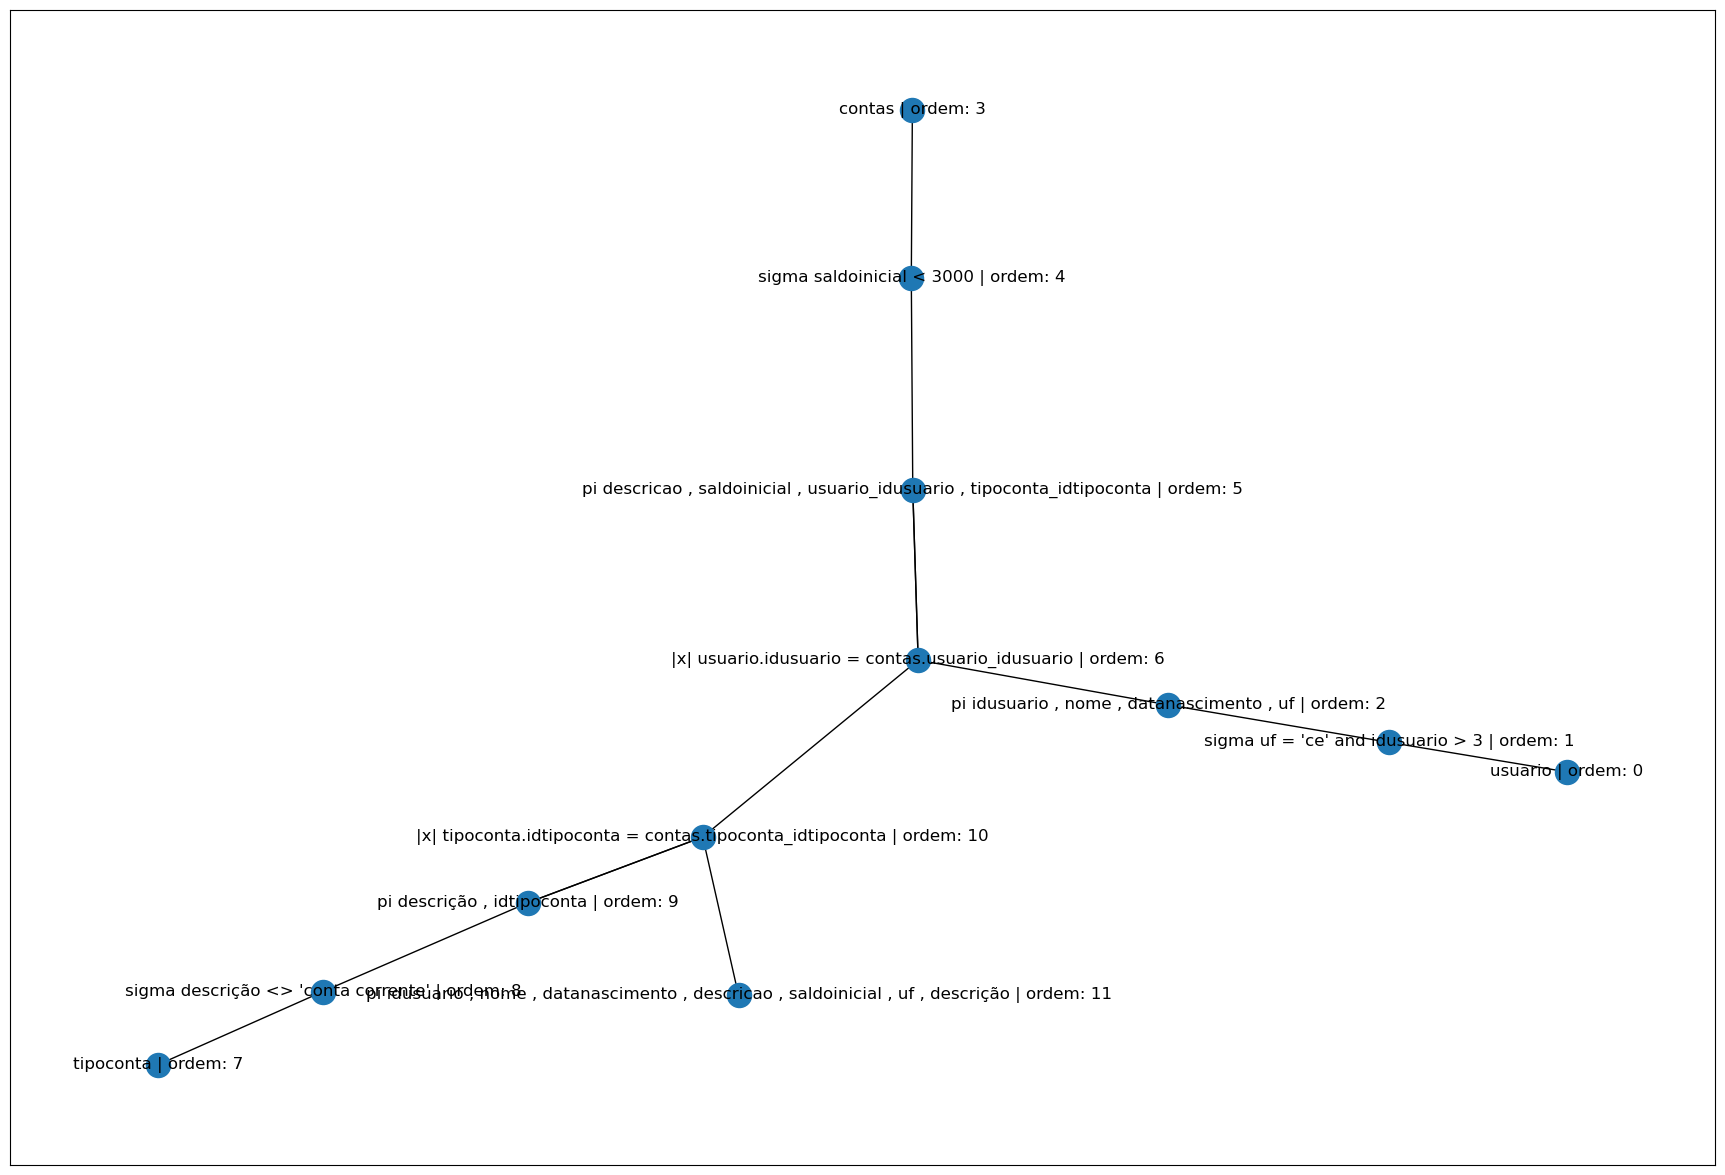

In [63]:
plt.figure(figsize=(22,15))

pos = nx.spring_layout(grafo_ord_exec)
nx.draw_networkx(grafo_ord_exec, pos, with_labels=True)
plt.show()

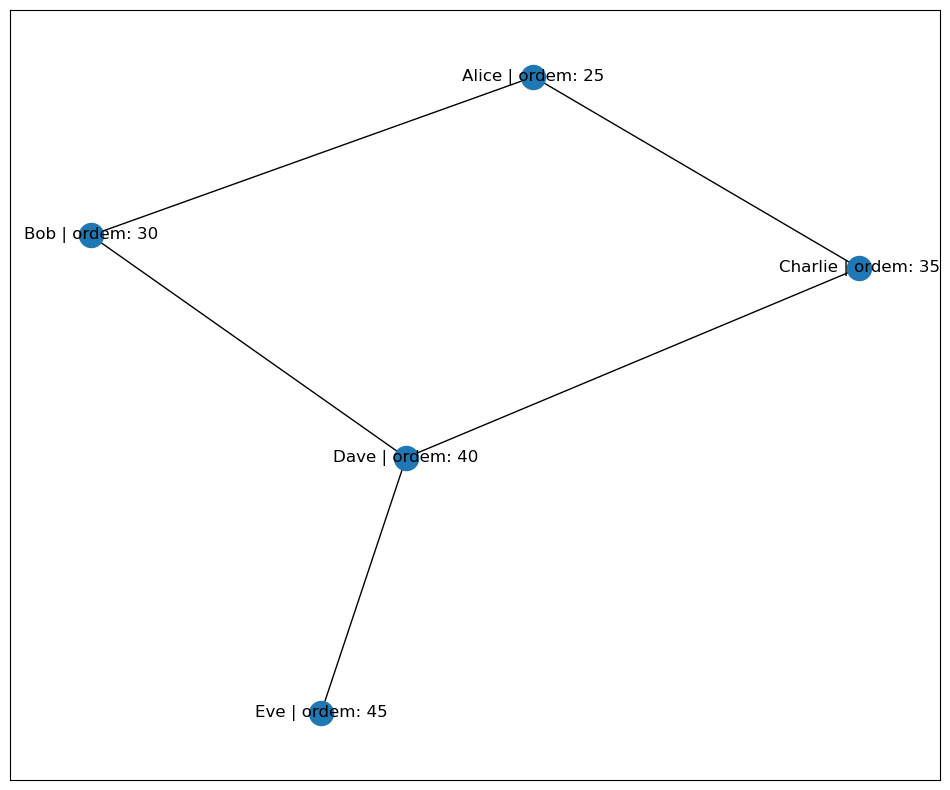

In [64]:
plt.figure(figsize=(12,10))

G = nx.MultiGraph()

alice = Vertice("Alice", 25)
bob = Vertice("Bob", 30)
charlie = Vertice("Charlie", 35)
dave = Vertice("Dave", 40)
eve = Vertice("Eve", 45)

G.add_node(alice)
G.add_node(bob)
G.add_node(charlie)
G.add_node(dave)
G.add_node(eve)

G.add_edge(alice, bob)
G.add_edge(alice, charlie)
G.add_edge(bob, dave)
G.add_edge(charlie, dave)
G.add_edge(dave, eve)

nx.draw_networkx(G, with_labels=True)
plt.show()